Analyzing treesequence output from SLiM


In [21]:
import msprime, tskit, pyslim, time 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import subprocess

In [6]:
orig_ts = tskit.load("../results/out.trees")

In [7]:
#Getting recombination information from slim simulation

#SLiM uses end positions while msprime uses start positions (msprime list will be n + 1)

Mut_rate = 1.5e-8
Rec_rate = 1e-8
#Amp_rec_rate = ??? SHOULD BE HIGHER

Chr_len = 9999
Sep_len = 2
Amplicon_len = 50
Sex_Chr_len = (Chr_len // 5) - Amplicon_len

'''   
SLiM code:

initializeRecombinationRate(c(Rec_rate, 0.5, Rec_rate, 0.5, 0, 0.5, 0, 0.5, 0, 0.5, 0, 0.5, 0),
		c(Chr_len, Chr_len + Sep_len,
		(Chr_len * 2) + Sep_len + 1,
		(Chr_len * 2) + (Sep_len * 2) + 1 + Amplicon_len,
		(Chr_len * 2) + (Sep_len * 2) + 2 + Amplicon_len + (Sex_Chr_len),
		(Chr_len * 2) + (Sep_len * 2) + 3 + (Amplicon_len * 2) + (Sex_Chr_len),
		(Chr_len * 2) + (Sep_len * 2) + 4 + (Amplicon_len * 2) + (Sex_Chr_len * 2),
		(Chr_len * 2) + (Sep_len * 2) + 5 + (Amplicon_len * 3) + (Sex_Chr_len * 2),
		(Chr_len * 2) + (Sep_len * 2) + 6 + (Amplicon_len * 3) + (Sex_Chr_len * 3),
		(Chr_len * 2) + (Sep_len * 2) + 7 + (Amplicon_len * 4) + (Sex_Chr_len * 3),
		(Chr_len * 2) + (Sep_len * 2) + 8 + (Amplicon_len * 4) + (Sex_Chr_len * 4),
		(Chr_len * 2) + (Sep_len * 2) + 9 + (Amplicon_len * 5) + (Sex_Chr_len * 4),
		(Chr_len * 2) + (Sep_len * 2) + 10 + (Amplicon_len * 5) + (Sex_Chr_len * 5)), sex="M");
        
        
initializeRecombinationRate(c(Rec_rate, 0.5, Rec_rate, 0.5, Rec_rate, 0.5, Rec_rate, 0.5, Rec_rate, 0.5, Rec_rate, 0.5, Rec_rate),
		c(Chr_len, Chr_len + Sep_len,
		(Chr_len * 2) + Sep_len + 1,
		(Chr_len * 2) + (Sep_len * 2) + 1,
		(Chr_len * 2) + (Sep_len * 2) + 2 + Amplicon_len + (Sex_Chr_len),
		(Chr_len * 2) + (Sep_len * 2) + 3 + (Amplicon_len * 2) + (Sex_Chr_len),
		(Chr_len * 2) + (Sep_len * 2) + 4 + (Amplicon_len * 2) + (Sex_Chr_len * 2),
		(Chr_len * 2) + (Sep_len * 2) + 5 + (Amplicon_len * 3) + (Sex_Chr_len * 2),
		(Chr_len * 2) + (Sep_len * 2) + 6 + (Amplicon_len * 3) + (Sex_Chr_len * 3),
		(Chr_len * 2) + (Sep_len * 2) + 7 + (Amplicon_len * 4) + (Sex_Chr_len * 3),
		(Chr_len * 2) + (Sep_len * 2) + 8 + (Amplicon_len * 4) + (Sex_Chr_len * 4),
		(Chr_len * 2) + (Sep_len * 2) + 9 + (Amplicon_len * 5) + (Sex_Chr_len * 4),
		(Chr_len * 2) + (Sep_len * 2) + 10 + (Amplicon_len * 5) + (Sex_Chr_len * 5)), sex="F");
}

'''
Positions = [Chr_len, Chr_len + Sep_len,
		(Chr_len * 2) + Sep_len + 1,
		(Chr_len * 2) + (Sep_len * 2) + 1,
		(Chr_len * 2) + (Sep_len * 2) + 2 + Amplicon_len + (Sex_Chr_len),
		(Chr_len * 2) + (Sep_len * 2) + 3 + (Amplicon_len * 2) + (Sex_Chr_len),
		(Chr_len * 2) + (Sep_len * 2) + 4 + (Amplicon_len * 2) + (Sex_Chr_len * 2),
		(Chr_len * 2) + (Sep_len * 2) + 5 + (Amplicon_len * 3) + (Sex_Chr_len * 2),
		(Chr_len * 2) + (Sep_len * 2) + 6 + (Amplicon_len * 3) + (Sex_Chr_len * 3),
		(Chr_len * 2) + (Sep_len * 2) + 7 + (Amplicon_len * 4) + (Sex_Chr_len * 3),
		(Chr_len * 2) + (Sep_len * 2) + 8 + (Amplicon_len * 4) + (Sex_Chr_len * 4),
		(Chr_len * 2) + (Sep_len * 2) + 9 + (Amplicon_len * 5) + (Sex_Chr_len * 4),
		(Chr_len * 2) + (Sep_len * 2) + 10 + (Amplicon_len * 5) + (Sex_Chr_len * 5)]

#No rec in males outside PAR
Male_Recrates = [Rec_rate, 0.5, Rec_rate, 0.5, 0, 0.5, 0, 0.5, 0, 0.5, 0, 0.5, 0]
Female_recrates = [Rec_rate, 0.5, Rec_rate, 0.5, Rec_rate, 0.5, Rec_rate, 0.5, Rec_rate, 0.5, Rec_rate, 0.5, Rec_rate] 

#Recombination maps in tsv files use cM/Mb as a standard
#Rescaling recombination rates accordingly:
Male_Recrates_scaled = [r / 1e-8 for r in Male_Recrates]
Female_Recrates_scaled = [r / 1e-8 for r in Female_recrates]

Female_Recrates_scaled


[1.0,
 50000000.0,
 1.0,
 50000000.0,
 1.0,
 50000000.0,
 1.0,
 50000000.0,
 1.0,
 50000000.0,
 1.0,
 50000000.0,
 1.0]

In [9]:
#Writing recombination rates in tsv file 
column_names = ["end_position", "rate(cM/Mb)"]

data = {"end_position" : Positions, "rate(cM/Mb)" : Female_Recrates_scaled}
df = pd.DataFrame(data)

df.to_csv(("../data/Female_recomb_rates.tsv"), sep='\t', index=False, header=column_names)

In [8]:
#Recapitation with a nonuniform recombination map
#WE HAVE 2 DIFFERENT MAPS FOR SEXES THIS NEEDS SOME OTHER CODE TO MAKE FEMALE/MALE NODES WITH DIFFERENT RECOMB MAPS <=== DAVIDE

positions = []
rates = []
with open('../data/Female_recomb_rates.tsv', 'r') as file:
  header = file.readline().strip().split("\t")
  assert(header[0] == "end_position" and header[1] == "rate(cM/Mb)")
  for line in file:
     components = line.split("\t")
     positions.append(float(components[0]))
     rates.append(1e-8 * float(components[1]))

# step 1
positions.insert(0, 0)
# step 2
positions[-1] += 1
assert positions[-1] == orig_ts.sequence_length

recomb_map = msprime.RateMap(position=positions, rate=rates)
rts = pyslim.recapitate(orig_ts,
                recombination_rate=recomb_map,
                ancestral_Ne=100)
assert(max([t.num_roots for t in rts.trees()]) == 1)

/home/davidec/miniconda3/envs/birc-project/lib/python3.12/site-packages/msprime/ancestry.py:1290: TimeUnitsMismatchWarning: The initial_state has time_units=ticks but time is measured in generations in msprime. This may lead to significant discrepancies between the timescales. If you wish to suppress this warning, you can use, e.g., warnings.simplefilter('ignore', msprime.TimeUnitsMismatchWarning)
  sim = _parse_sim_ancestry(


In [9]:
rts

In [24]:
orig_ts = tskit.load("../results/out.trees")

In [11]:
#Simplification: discarding less informing nodes from tree
#Here this is done without recapitation, directly from output file orig_ts.

import numpy as np
rng = np.random.default_rng(seed=3)
alive_inds = pyslim.individuals_alive_at(rts, 0)
#alive_inds = pyslim.individuals_alive_at(orig_ts, 0)
keep_indivs = rng.choice(alive_inds, 100, replace=False)
keep_nodes = []
for i in keep_indivs:
  keep_nodes.extend(rts.individual(i).nodes)
  #keep_nodes.extend(orig_ts.individual(i).nodes)

sts = rts.simplify(keep_nodes, keep_input_roots=True) #WITH RECAPITATION %%%All other orig_ts => rts
#sts = orig_ts.simplify(keep_nodes, keep_input_roots=True) #WITHOUT RECAPITATION


print(f"Before, there were {rts.num_samples} sample nodes (and {rts.num_individuals} individuals)\n"
      f"in the tree sequence, and now there are {sts.num_samples} sample nodes\n"
      f"(and {sts.num_individuals} individuals).")


'''
print(f"Before, there were {orig_ts.num_samples} sample nodes (and {orig_ts.num_individuals} individuals)\n"
      f"in the tree sequence, and now there are {sts.num_samples} sample nodes\n"
      f"(and {sts.num_individuals} individuals).") 
'''

Before, there were 214 sample nodes (and 107 individuals)
in the tree sequence, and now there are 200 sample nodes
(and 105 individuals).


'\nprint(f"Before, there were {orig_ts.num_samples} sample nodes (and {orig_ts.num_individuals} individuals)\n"\n      f"in the tree sequence, and now there are {sts.num_samples} sample nodes\n"\n      f"(and {sts.num_individuals} individuals).") \n'

In [12]:
#Adding neutral mutation types after the simulation has occured
#ACTUALLY WE HAVE ONLY NEUTRAL MUTATION TYPES IN OUR SIMULATION <====== DAVIDE
next_id = pyslim.next_slim_mutation_id(sts)
ts = msprime.sim_mutations(
           sts,
           rate=Mut_rate,
           model=msprime.SLiMMutationModel(type=0, next_id=next_id), #using mutation type 0 because its not used in SLiM 
           keep=True, #keeps other mut types 
)

print(f"The tree sequence now has {ts.num_mutations} mutations,\n"
      f"and mean pairwise nucleotide diversity is {ts.diversity():0.3e}.")

The tree sequence now has 180 mutations,
and mean pairwise nucleotide diversity is 3.369e-04.


In [13]:
ts

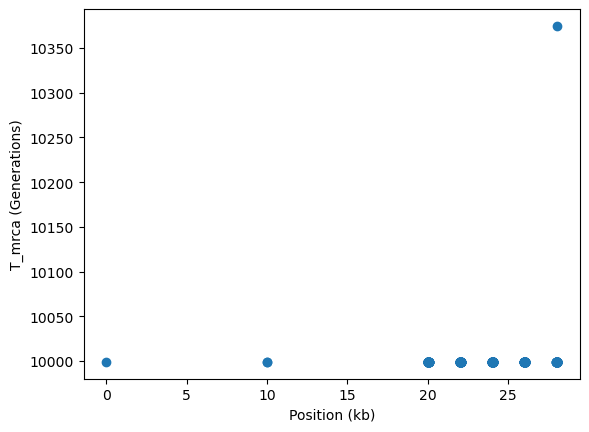

In [16]:
#Plotting TMRCA for given tree sequence 
#Skips trees with multiple branches so can run without recapitation

#counting how many trees has more than one branch 
trees_onebranch = [tree for tree in ts.trees() if len(tree.roots) == 1]

tmrca = np.zeros(len(trees_onebranch)) #initializing lists
breakpoints = np.zeros(len(trees_onebranch))
for tree in ts.trees():
    if len(tree.roots) == 1: #skipping trees with multiple roots
        tmrca[tree.index] = tree.time(tree.root)
        breakpoints[tree.index] = tree.interval[0]
plt.ylabel("T_mrca (Generations)")
plt.xlabel("Position (kb)")
plt.plot(breakpoints / 1000, tmrca, "o")

In [ ]:
#Plotting TMRCA for given tree sequence 
tmrca = np.zeros(len(ts.trees())) #initializing lists
breakpoints = np.zeros(len(ts.trees()))
for tree in ts.trees():
    tmrca[tree.index] = tree.time(tree.root)
    breakpoints[tree.index] = tree.interval[0]
plt.ylabel("T_mrca (Generations)")
plt.xlabel("Position (kb)")
plt.plot(breakpoints / 1000, tmrca, "o")

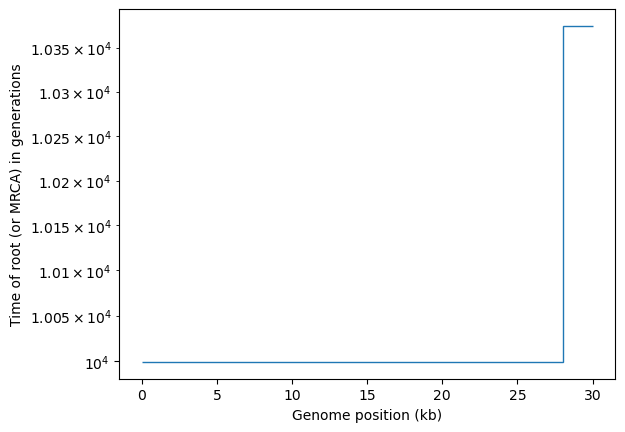

In [24]:
kb = [0]  # Starting genomic position
mrca_time = []
for tree in ts.trees():
    kb.append(tree.interval.right/1000)  # convert to kb
    mrca = ts.node(tree.root)  # For msprime tree sequences, the root node is the MRCA
    mrca_time.append(mrca.time)
plt.stairs(mrca_time, kb, baseline=None)
plt.xlabel("Genome position (kb)")
plt.ylabel("Time of root (or MRCA) in generations")
plt.yscale("log")

Tree number 1, which runs from position 10000.0 to 10001.0:


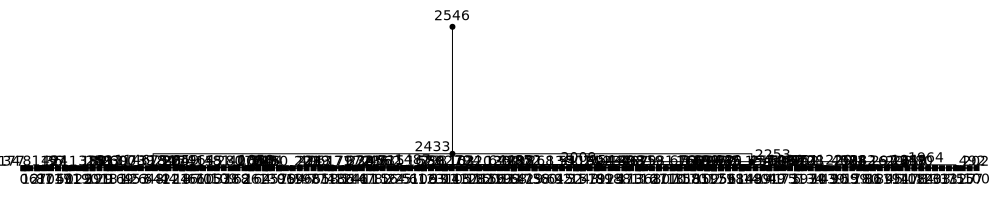

In [26]:
swept_tree = ts.at(10_000)  # or you can get e.g. the nth tree using ts.at_index(n)
intvl = swept_tree.interval
print(f"Tree number {swept_tree.index}, which runs from position {intvl.left} to {intvl.right}:")
# Draw it at a wide size, to make room for all 40 tips
swept_tree.draw_svg(size=(1000, 200))

Genealogy of the first 10 samples for the first 5kb of the genome


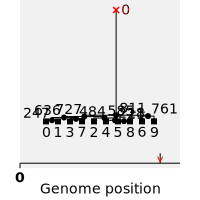

In [27]:
reduced_ts = ts.simplify([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])  # simplify to the first 10 samples
print("Genealogy of the first 10 samples for the first 5kb of the genome")
reduced_ts.draw_svg(x_lim=(0, 5000))

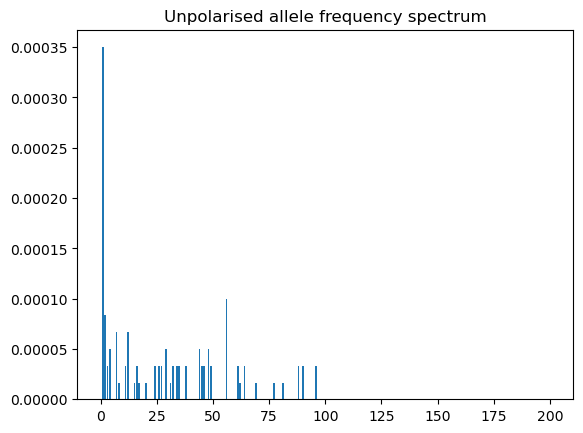

In [28]:
afs = ts.allele_frequency_spectrum()
plt.bar(np.arange(ts.num_samples + 1), afs)
plt.title("Unpolarised allele frequency spectrum")
plt.show()

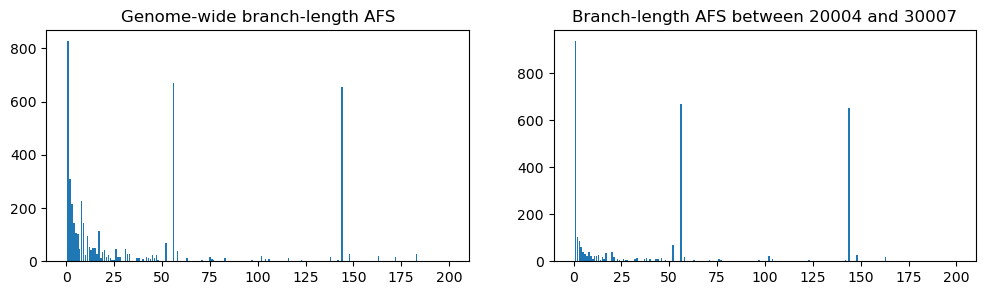

In [29]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 3))

afs1 = ts.allele_frequency_spectrum(polarised=True, mode="branch")
ax1.bar(np.arange(ts.num_samples+1), afs1)
ax1.set_title("Genome-wide branch-length AFS")

restricted_ts = ts.keep_intervals([[(Chr_len * 2) + (Sep_len * 2) + 2, (Chr_len * 2) + (Sep_len * 2) + 10 + (Amplicon_len * 5) + (Sex_Chr_len * 5)]])
afs2 = restricted_ts.allele_frequency_spectrum(polarised=True, mode="branch")
ax2.bar(np.arange(restricted_ts.num_samples+1), afs2)
ax2.set_title(f"Branch-length AFS between {(Chr_len * 2) + (Sep_len * 2) + 2} and {(Chr_len * 2) + (Sep_len * 2) + 10 + (Amplicon_len * 5) + (Sex_Chr_len * 5)}")

plt.show()

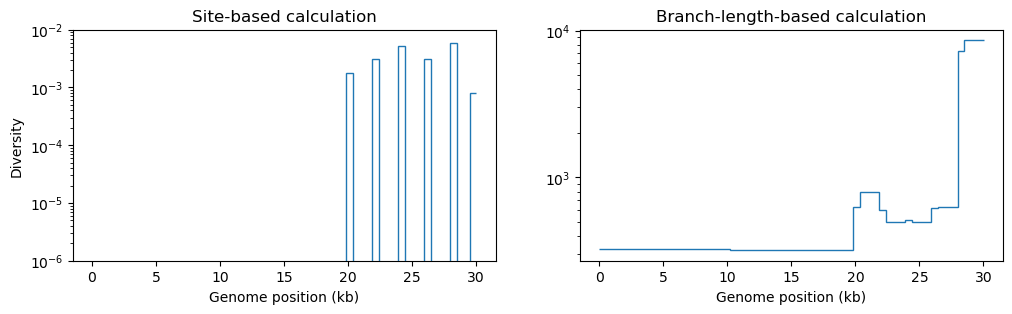

In [51]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 3))
L = int(ts.sequence_length)
windows = np.linspace(0, L, num=L//500)
ax1.stairs(ts.diversity(windows=windows), windows/1_000, baseline=None)  # Default is mode="site"
ax1.set_ylabel("Diversity")
ax1.set_xlabel("Genome position (kb)")
ax1.set_title("Site-based calculation")
#ax1.set_xlim(4e3, 6e3)
ax1.set_yscale("log")
ax1.set_ylim(1e-6, 1e-2)
ax2.stairs(ts.diversity(windows=windows, mode="branch"), windows/1_000, baseline=None)
ax2.set_xlabel("Genome position (kb)")
ax2.set_title("Branch-length-based calculation")
#ax2.set_xlim(4e3, 6e3)
ax2.set_yscale("log")
plt.show()

Diversity is higher in ampliconic regions as expected


In [53]:
d = ts.diversity()
print(f"Average diversity per unit sequence length = {d:.3G}")

Average diversity per unit sequence length = 0.000337


In [55]:
windows = np.linspace(0, ts.sequence_length, num=5)
d = ts.diversity(windows=windows)
print(windows, d, sep="\n")

[    0.  7502. 15004. 22506. 30008.]
[0.         0.         0.00032951 0.00101813]
